In [ ]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import warnings
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

warnings.filterwarnings('ignore')

# 设置绘图样式
sns.set_style("whitegrid")

print("Libraries imported successfully!")
print(f"Algorithm: FP-growth")
print(f"Number of datasets: 8 (4 transaction variations + 4 item variations)")

Libraries imported successfully!
Algorithm: FP-growth
Number of datasets: 8 (4 transaction variations + 4 item variations)


In [ ]:
# 加载已有结果
RESULTS_DIR = 'results'
results_file = os.path.join(RESULTS_DIR, 'fpgrowth_performance_comparison.csv')
results_df = pd.read_csv(results_file)

print(f"Results loaded from: {results_file}")
print(f"Number of datasets: {len(results_df)}")
print(f"\nDataset summary:")
print(results_df[['dataset', 'num_transactions', 'num_items', 'fpgrowth_total_time']].to_string(index=False))

Results loaded from: results\fpgrowth_performance_comparison.csv
Number of datasets: 8

Dataset summary:
            dataset  num_transactions  num_items  fpgrowth_total_time
 dataset1_trans_25%              4947       3606            12.816009
 dataset2_trans_50%              9894       3780            20.117529
 dataset3_trans_75%             14843       3876            37.527868
dataset4_trans_100%             19791       3916            42.879769
 dataset5_items_25%             19144        979            55.358833
 dataset6_items_50%             19538       1958            60.407749
 dataset7_items_75%             19726       2937            60.086123
dataset8_items_100%             19791       3916            50.722614


In [3]:
"""
=============================================================================
第1部分: 配置参数和目录
=============================================================================
"""

# 目录配置
DATASETS_DIR = 'datasets'
RESULTS_DIR = 'results'

# 算法参数
MIN_SUPPORT = 0.01      # 最小支持度 1%
MIN_CONFIDENCE = 0.5    # 最小置信度 50%
MIN_LIFT = 1.0          # 最小提升度

# 暴力破解估算参数
COST_PER_CHECK = 1e-8   # 假设检查一个项集需要10纳秒

# 确保结果目录存在
os.makedirs(RESULTS_DIR, exist_ok=True)

# 获取所有数据集文件
dataset_files = sorted([f for f in os.listdir(DATASETS_DIR) if f.endswith('.csv')])

print("=" * 80)
print("Configuration Information")
print("=" * 80)
print(f"Dataset directory: {DATASETS_DIR}")
print(f"Results directory: {RESULTS_DIR}")
print(f"\nAlgorithm parameters:")
print(f"  Minimum support: {MIN_SUPPORT * 100}%")
print(f"  Minimum confidence: {MIN_CONFIDENCE * 100}%")
print(f"  Minimum lift: {MIN_LIFT}")
print(f"\nDatasets found: {len(dataset_files)}")
for i, f in enumerate(dataset_files, 1):
    print(f"  {i}. {f}")

Configuration Information
Dataset directory: datasets
Results directory: results

Algorithm parameters:
  Minimum support: 1.0%
  Minimum confidence: 50.0%
  Minimum lift: 1.0

Datasets found: 9
  1. dataset1_trans_25%.csv
  2. dataset2_trans_50%.csv
  3. dataset3_trans_75%.csv
  4. dataset4_trans_100%.csv
  5. dataset5_items_25%.csv
  6. dataset6_items_50%.csv
  7. dataset7_items_75%.csv
  8. dataset8_items_100%.csv
  9. datasets_statistics.csv


In [4]:
"""
=============================================================================
第2部分: 核心函数定义
=============================================================================
"""

def load_and_prepare_data(dataset_path):
    """
    加载数据集并转换为FP-growth所需的格式
    
    参数:
        dataset_path: 数据集CSV文件路径
    
    返回:
        df_encoded: one-hot编码的DataFrame
        num_transactions: 交易数量
        num_items: 唯一商品数量
    """
    # 读取数据
    df = pd.read_csv(dataset_path, encoding='latin1')
    
    # 按InvoiceNo分组，将StockCode转换为列表
    transactions = df.groupby('InvoiceNo')['StockCode'].apply(list).values
    
    # 使用TransactionEncoder转换为one-hot编码
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
    
    num_transactions = len(df_encoded)
    num_items = len(df_encoded.columns)
    
    return df_encoded, num_transactions, num_items


def run_fpgrowth_algorithm(df_encoded, min_support, min_confidence, min_lift):
    """
    使用FP-growth算法进行关联规则挖掘，分别测量频繁项集和规则生成时间
    
    参数:
        df_encoded: one-hot编码的DataFrame
        min_support: 最小支持度
        min_confidence: 最小置信度
        min_lift: 最小提升度
    
    返回:
        results: 包含时间和统计信息的字典
        frequent_itemsets: 频繁项集DataFrame
        rules: 关联规则DataFrame
    """
    # 1. 频繁项集生成（单独计时）
    start_freq = time.time()
    frequent_itemsets = fpgrowth(df_encoded, min_support=min_support, use_colnames=True)
    end_freq = time.time()
    freq_time = end_freq - start_freq
    
    # 2. 关联规则生成（单独计时）
    start_rules = time.time()
    if len(frequent_itemsets) > 0:
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
        # 过滤提升度
        rules = rules[rules['lift'] >= min_lift]
    else:
        rules = pd.DataFrame()
    end_rules = time.time()
    rules_time = end_rules - start_rules
    
    # 3. 总时间
    total_time = freq_time + rules_time
    
    results = {
        'freq_time': freq_time,
        'rules_time': rules_time,
        'total_time': total_time,
        'num_freq_itemsets': len(frequent_itemsets),
        'num_rules': len(rules)
    }
    
    return results, frequent_itemsets, rules


def estimate_bruteforce_time(num_transactions, num_items, min_support):
    """
    理论估算暴力破解方法所需时间（不实际运行代码）
    
    暴力破解方法理论分析:
    ----------------------
    1. 枚举所有可能的项集: 2^m - 1 个（m为商品数量）
    2. 对每个项集，扫描所有n个交易来计算支持度
    3. 时间复杂度: O(n × 2^m)
    
    理论时间估算公式:
    T_bruteforce = n × (2^m - 1) × cost_per_check
    
    其中:
    - n: 交易数量
    - m: 唯一商品数量
    - cost_per_check: 检查一个项集在一个交易中是否出现的时间（假设10纳秒）
    
    参数:
        num_transactions: 交易数量
        num_items: 商品数量
        min_support: 最小支持度（未使用，但保留接口一致性）
    
    返回:
        estimated_time: 估算时间（秒），如果过大则返回inf
        log_time: log10(estimated_time)，用于可视化
    """
    # 计算需要检查的项集数量
    num_itemsets = 2 ** num_items - 1
    
    # 理论总操作次数
    total_operations = num_transactions * num_itemsets
    
    # 估算总时间（秒）
    estimated_time = total_operations * COST_PER_CHECK
    
    # 计算对数值（用于可视化和避免溢出）
    if estimated_time > 0:
        log_time = np.log10(estimated_time)
    else:
        log_time = -np.inf
    
    # 如果时间超过1年，标记为不可行
    if estimated_time > 365 * 24 * 3600:
        return float('inf'), log_time
    
    return estimated_time, log_time


print("=" * 80)
print("Core Functions Defined")
print("=" * 80)
print("Function list:")
print("  1. load_and_prepare_data() - Data loading and preprocessing")
print("  2. run_fpgrowth_algorithm() - FP-growth execution (with separate timing)")
print("  3. estimate_bruteforce_time() - Brute-force theoretical estimation")
print("\nBrute-force time complexity: O(n × 2^m)")
print("   n = number of transactions, m = number of items")

Core Functions Defined
Function list:
  1. load_and_prepare_data() - Data loading and preprocessing
  2. run_fpgrowth_algorithm() - FP-growth execution (with separate timing)
  3. estimate_bruteforce_time() - Brute-force theoretical estimation

Brute-force time complexity: O(n × 2^m)
   n = number of transactions, m = number of items


In [5]:
# 确保导入FP-growth算法
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd
import numpy as np
import time

print("FP-growth related modules imported")

FP-growth related modules imported


In [6]:
# 修复后的暴力破解时间估算函数
def estimate_bruteforce_time(num_transactions, num_items, min_support):
    """
    理论估算暴力破解方法所需时间（修复overflow问题）
    """
    # 首先计算对数，避免overflow
    # log(n × 2^m × cost) = log(n) + m×log(2) + log(cost)
    
    log_n = np.log10(num_transactions)
    log_2_power_m = num_items * np.log10(2)  # log10(2^m) = m * log10(2)
    log_cost = np.log10(COST_PER_CHECK)
    
    # 总时间的对数
    log_time = log_n + log_2_power_m + log_cost
    
    # 尝试计算实际值（如果不太大）
    if log_time < 300:  # 10^300以下才计算实际值
        try:
            # 使用对数重新计算避免中间溢出
            estimated_time = 10 ** log_time
        except (OverflowError, ValueError):
            estimated_time = float('inf')
    else:
        estimated_time = float('inf')
    
    return estimated_time, log_time

print("estimate_bruteforce_time function fixed (overflow avoided)")

estimate_bruteforce_time function fixed (overflow avoided)


In [7]:
"""
=============================================================================
第3部分: 执行性能测试
=============================================================================
"""

# 存储所有结果
all_results = []

print("\n" + "=" * 80)
print("Starting Performance Testing...")
print("=" * 80)

for idx, dataset_file in enumerate(dataset_files, 1):
    print(f"\n{'='*80}")
    print(f"Testing Dataset [{idx}/{len(dataset_files)}]: {dataset_file}")
    print(f"{'='*80}")
    
    dataset_path = os.path.join(DATASETS_DIR, dataset_file)
    dataset_name = dataset_file.replace('.csv', '')
    
    try:
        # 步骤1: 加载和准备数据
        print(f"  Loading data...")
        df_encoded, num_trans, num_items = load_and_prepare_data(dataset_path)
        print(f"     Transactions: {num_trans:,}")
        print(f"     Items: {num_items:,}")
        
        # 步骤2: 运行FP-growth算法
        print(f"  Running FP-growth algorithm...")
        fpgrowth_results, freq_itemsets, rules = run_fpgrowth_algorithm(
            df_encoded, MIN_SUPPORT, MIN_CONFIDENCE, MIN_LIFT
        )
        
        print(f"     - Frequent itemset generation time: {fpgrowth_results['freq_time']:.4f} seconds")
        print(f"     - Rule generation time: {fpgrowth_results['rules_time']:.4f} seconds")
        print(f"     - Total time: {fpgrowth_results['total_time']:.4f} seconds")
        print(f"     - Frequent itemsets found: {fpgrowth_results['num_freq_itemsets']:,}")
        print(f"     - Rules generated: {fpgrowth_results['num_rules']:,}")
        
        # 步骤3: 估算暴力破解时间（理论）
        print(f"  Estimating brute-force time (theoretical)...")
        bruteforce_time, log_bruteforce_time = estimate_bruteforce_time(
            num_trans, num_items, MIN_SUPPORT
        )
        
        if bruteforce_time == float('inf'):
            print(f"     Estimated time: 10^{log_bruteforce_time:.2f} seconds (astronomical, infeasible)")
            print(f"     Equivalent to: 10^{log_bruteforce_time - np.log10(365*24*3600):.2f} years")
        else:
            print(f"     Estimated time: {bruteforce_time:.2e} seconds ({bruteforce_time/3600:.2e} hours)")
        
        # 步骤4: 计算加速比
        if fpgrowth_results['total_time'] > 0:
            speedup = bruteforce_time / fpgrowth_results['total_time']
        else:
            speedup = float('inf')
        
        if speedup != float('inf'):
            print(f"  FP-growth speedup: {speedup:.2e}x")
        else:
            print(f"  FP-growth speedup: Infinity (measured time near 0)")
        
        # 记录结果
        all_results.append({
            'dataset': dataset_name,
            'num_transactions': num_trans,
            'num_items': num_items,
            'freq_time': fpgrowth_results['freq_time'],
            'rules_time': fpgrowth_results['rules_time'],
            'fpgrowth_total_time': fpgrowth_results['total_time'],
            'bruteforce_time': bruteforce_time,
            'log_bruteforce_time': log_bruteforce_time,
            'speedup': speedup,
            'num_freq_itemsets': fpgrowth_results['num_freq_itemsets'],
            'num_rules': fpgrowth_results['num_rules']
        })
        
        # 保存Top 10规则
        if len(rules) > 0:
            top_rules = rules.nlargest(10, 'lift')[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
            rules_file = os.path.join(RESULTS_DIR, f"{dataset_name}_top_rules.csv")
            top_rules.to_csv(rules_file, index=False, encoding='utf-8-sig')
            print(f"  Top 10 rules saved to: {rules_file}")
        
        print(f"  {dataset_name} testing completed")
        
    except Exception as e:
        print(f"  Error: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n{'='*80}")
print("All datasets testing completed!")
print("=" * 80)


Starting Performance Testing...

Testing Dataset [1/9]: dataset1_trans_25%.csv
  Loading data...
     Transactions: 4,947
     Items: 3,606
  Running FP-growth algorithm...
     Transactions: 4,947
     Items: 3,606
  Running FP-growth algorithm...
     - Frequent itemset generation time: 7.2589 seconds
     - Rule generation time: 0.0156 seconds
     - Total time: 7.2745 seconds
     - Frequent itemsets found: 2,127
     - Rules generated: 1,224
  Estimating brute-force time (theoretical)...
     Estimated time: 10^1081.21 seconds (astronomical, infeasible)
     Equivalent to: 10^1073.71 years
  FP-growth speedup: Infinity (measured time near 0)
  Top 10 rules saved to: results\dataset1_trans_25%_top_rules.csv
  dataset1_trans_25% testing completed

Testing Dataset [2/9]: dataset2_trans_50%.csv
  Loading data...
     - Frequent itemset generation time: 7.2589 seconds
     - Rule generation time: 0.0156 seconds
     - Total time: 7.2745 seconds
     - Frequent itemsets found: 2,127
  

Traceback (most recent call last):
  File "C:\Users\weiyu hou\AppData\Local\Temp\ipykernel_31616\3331296667.py", line 25, in <module>
    df_encoded, num_trans, num_items = load_and_prepare_data(dataset_path)
  File "C:\Users\weiyu hou\AppData\Local\Temp\ipykernel_31616\3482501635.py", line 23, in load_and_prepare_data
    transactions = df.groupby('InvoiceNo')['StockCode'].apply(list).values
  File "c:\Python\lib\site-packages\pandas\core\frame.py", line 9210, in groupby
    return DataFrameGroupBy(
  File "c:\Python\lib\site-packages\pandas\core\groupby\groupby.py", line 1331, in __init__
    grouper, exclusions, obj = get_grouper(
  File "c:\Python\lib\site-packages\pandas\core\groupby\grouper.py", line 1043, in get_grouper
    raise KeyError(gpr)
KeyError: 'InvoiceNo'


In [8]:
"""
=============================================================================
第4部分: 结果汇总和保存
=============================================================================
"""

# 创建结果DataFrame
results_df = pd.DataFrame(all_results)

# 保存到CSV
results_file = os.path.join(RESULTS_DIR, 'fpgrowth_performance_comparison.csv')
results_df.to_csv(results_file, index=False, encoding='utf-8-sig')

print("\n" + "=" * 80)
print("Performance Test Results Summary")
print("=" * 80)
print(f"\nResults saved to: {results_file}\n")

# 显示结果表格
print(results_df.to_string(index=False))

print("\n" + "=" * 80)
print("Statistical Summary")
print("=" * 80)

# 分组统计
trans_group = results_df[results_df['dataset'].str.contains('trans')].copy()
items_group = results_df[results_df['dataset'].str.contains('items')].copy()

print("\nTransaction Variation Group:")
print(f"  Average FP-growth time: {trans_group['fpgrowth_total_time'].mean():.4f} seconds")
print(f"  Average frequent itemsets: {trans_group['num_freq_itemsets'].mean():.0f}")
print(f"  Average rules: {trans_group['num_rules'].mean():.0f}")

print("\nItem Variation Group:")
print(f"  Average FP-growth time: {items_group['fpgrowth_total_time'].mean():.4f} seconds")
print(f"  Average frequent itemsets: {items_group['num_freq_itemsets'].mean():.0f}")
print(f"  Average rules: {items_group['num_rules'].mean():.0f}")

print("\n" + "=" * 80)


Performance Test Results Summary

Results saved to: results\fpgrowth_performance_comparison.csv

            dataset  num_transactions  num_items  freq_time  rules_time  fpgrowth_total_time  bruteforce_time  log_bruteforce_time       speedup  num_freq_itemsets  num_rules
 dataset1_trans_25%              4947       3606   7.258939    0.015582             7.274521              inf          1081.208506           inf               2127       1224
 dataset2_trans_50%              9894       3780  12.196029    0.005841            12.201869              inf          1133.888756           inf               1897       1000
 dataset3_trans_75%             14843       3876  21.744802    0.005354            21.750156              inf          1162.963785           inf               2123       1087
dataset4_trans_100%             19791       3916  25.820409    0.009652            25.830060              inf          1175.129931           inf               2007        956
 dataset5_items_25%        

Chart saved to: results\fpgrowth_vs_bruteforce_comparison.png


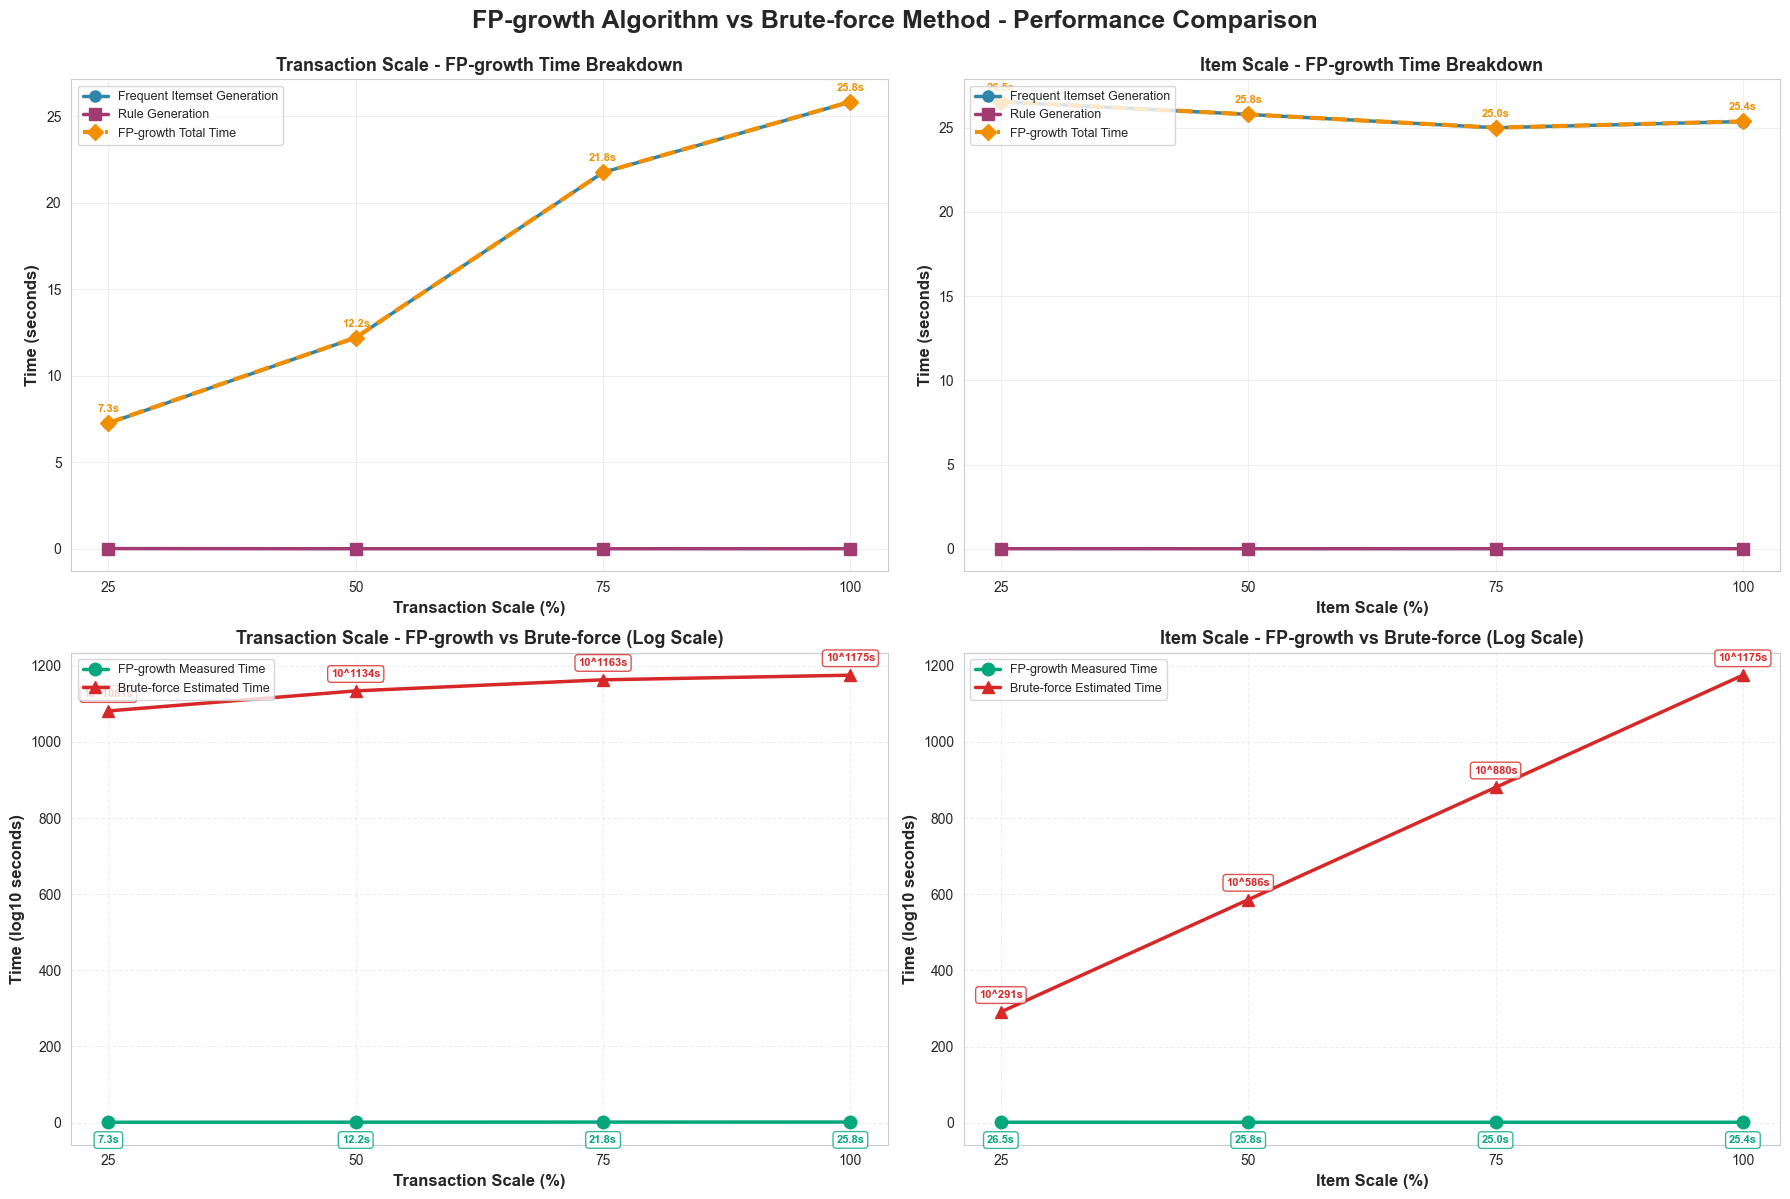

In [ ]:
"""
=============================================================================
第5部分: 可视化 - FP-growth实测时间 vs 暴力破解估算时间
=============================================================================
"""

# 准备数据
trans_group = results_df[results_df['dataset'].str.contains('trans')].copy()
items_group = results_df[results_df['dataset'].str.contains('items')].copy()

# 提取数据规模百分比
trans_group['scale'] = trans_group['dataset'].str.extract(r'(\d+)%')[0].astype(int)
items_group['scale'] = items_group['dataset'].str.extract(r'(\d+)%')[0].astype(int)

# 对数转换（用于可视化）
trans_group['log_fpgrowth_time'] = np.log10(trans_group['fpgrowth_total_time'] + 1e-10)
items_group['log_fpgrowth_time'] = np.log10(items_group['fpgrowth_total_time'] + 1e-10)

# 创建图表 - 2行2列布局，对比图在同一列
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('FP-growth Algorithm vs Brute-force Method - Performance Comparison', fontsize=18, fontweight='bold', y=0.995)

# ============ 左上图: 交易规模 - 时间分解（线性） ============
ax1 = axes[0, 0]
ax1.plot(trans_group['scale'], trans_group['freq_time'], 
         marker='o', linewidth=2.5, markersize=8, label='Frequent Itemset Generation', color='#2E86AB')
ax1.plot(trans_group['scale'], trans_group['rules_time'], 
         marker='s', linewidth=2.5, markersize=8, label='Rule Generation', color='#A23B72')
ax1.plot(trans_group['scale'], trans_group['fpgrowth_total_time'], 
         marker='D', linewidth=3, markersize=8, label='FP-growth Total Time', color='#F18F01', linestyle='--')

# 在数据点上标注具体数值
for idx, row in trans_group.iterrows():
    ax1.annotate(f'{row["fpgrowth_total_time"]:.1f}s', 
                xy=(row['scale'], row['fpgrowth_total_time']),
                xytext=(0, 8), textcoords='offset points',
                ha='center', fontsize=8, color='#F18F01', fontweight='bold')

ax1.set_xlabel('Transaction Scale (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Transaction Scale - FP-growth Time Breakdown', fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(trans_group['scale'])

# ============ 左下图: 交易规模 - FP-growth vs 暴力破解（对数） ============
ax2 = axes[1, 0]
ax2.plot(trans_group['scale'], trans_group['log_fpgrowth_time'], 
         marker='o', linewidth=2.5, markersize=9, label='FP-growth Measured Time', color='#06A77D')
ax2.plot(trans_group['scale'], trans_group['log_bruteforce_time'], 
         marker='^', linewidth=2.5, markersize=9, label='Brute-force Estimated Time', color='#D62828')

# 在数据点上标注具体数值
for idx, row in trans_group.iterrows():
    # FP-growth时间标注
    ax2.annotate(f'{row["fpgrowth_total_time"]:.1f}s', 
                xy=(row['scale'], row['log_fpgrowth_time']),
                xytext=(0, -15), textcoords='offset points',
                ha='center', fontsize=8, color='#06A77D', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#06A77D', alpha=0.8))
    
    # 暴力破解时间标注
    ax2.annotate(f'10^{row["log_bruteforce_time"]:.0f}s', 
                xy=(row['scale'], row['log_bruteforce_time']),
                xytext=(0, 10), textcoords='offset points',
                ha='center', fontsize=8, color='#D62828', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#D62828', alpha=0.8))

ax2.set_xlabel('Transaction Scale (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Time (log10 seconds)', fontsize=12, fontweight='bold')
ax2.set_title('Transaction Scale - FP-growth vs Brute-force (Log Scale)', fontsize=13, fontweight='bold')
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xticks(trans_group['scale'])

# ============ 右上图: 商品规模 - 时间分解（线性） ============
ax3 = axes[0, 1]
ax3.plot(items_group['scale'], items_group['freq_time'], 
         marker='o', linewidth=2.5, markersize=8, label='Frequent Itemset Generation', color='#2E86AB')
ax3.plot(items_group['scale'], items_group['rules_time'], 
         marker='s', linewidth=2.5, markersize=8, label='Rule Generation', color='#A23B72')
ax3.plot(items_group['scale'], items_group['fpgrowth_total_time'], 
         marker='D', linewidth=3, markersize=8, label='FP-growth Total Time', color='#F18F01', linestyle='--')

# 在数据点上标注具体数值
for idx, row in items_group.iterrows():
    ax3.annotate(f'{row["fpgrowth_total_time"]:.1f}s', 
                xy=(row['scale'], row['fpgrowth_total_time']),
                xytext=(0, 8), textcoords='offset points',
                ha='center', fontsize=8, color='#F18F01', fontweight='bold')

ax3.set_xlabel('Item Scale (%)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax3.set_title('Item Scale - FP-growth Time Breakdown', fontsize=13, fontweight='bold')
ax3.legend(loc='upper left', fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.set_xticks(items_group['scale'])

# ============ 右下图: 商品规模 - FP-growth vs 暴力破解（对数） ============
ax4 = axes[1, 1]
ax4.plot(items_group['scale'], items_group['log_fpgrowth_time'], 
         marker='o', linewidth=2.5, markersize=9, label='FP-growth Measured Time', color='#06A77D')
ax4.plot(items_group['scale'], items_group['log_bruteforce_time'], 
         marker='^', linewidth=2.5, markersize=9, label='Brute-force Estimated Time', color='#D62828')

# 在数据点上标注具体数值
for idx, row in items_group.iterrows():
    # FP-growth时间标注
    ax4.annotate(f'{row["fpgrowth_total_time"]:.1f}s', 
                xy=(row['scale'], row['log_fpgrowth_time']),
                xytext=(0, -15), textcoords='offset points',
                ha='center', fontsize=8, color='#06A77D', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#06A77D', alpha=0.8))
    
    # 暴力破解时间标注
    ax4.annotate(f'10^{row["log_bruteforce_time"]:.0f}s', 
                xy=(row['scale'], row['log_bruteforce_time']),
                xytext=(0, 10), textcoords='offset points',
                ha='center', fontsize=8, color='#D62828', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#D62828', alpha=0.8))

ax4.set_xlabel('Item Scale (%)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Time (log10 seconds)', fontsize=12, fontweight='bold')
ax4.set_title('Item Scale - FP-growth vs Brute-force (Log Scale)', fontsize=13, fontweight='bold')
ax4.legend(loc='upper left', fontsize=9)
ax4.grid(True, alpha=0.3, linestyle='--')
ax4.set_xticks(items_group['scale'])

plt.tight_layout()
plot_file = os.path.join(RESULTS_DIR, 'fpgrowth_vs_bruteforce_comparison.png')
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"Chart saved to: {plot_file}")
plt.show()